In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
# show all columns when displaying a data frame
pd.set_option('display.max_columns', None)

In [2]:
# do the different csv files contain the same projects at different times?
n_csv = 55

# load all csvs, extract project ids and add them to a set
id_set = set()
rows = 0
for i in range(n_csv+1):
    file_str = 'data/Kickstarter{0:03d}.csv'.format(i)
    df = pd.read_csv(file_str)
    # add all unique ids to set
    ids = df.id.unique()
    id_set.update(ids)
    rows += len(df)

print(f'Total rows: {rows} Total unique ids: {len(id_set)}')
# we can see that there are many unique ids, but also some duplicates



Total rows: 209222 Total unique ids: 182264


In [3]:
# what do instances with the same id have in common (if anything?)
# let's investigate one example to get a feeling for it
df1 = pd.read_csv('data/Kickstarter000.csv')
df2 = pd.read_csv('data/Kickstarter034.csv')
common_ids = np.intersect1d(df1.id.unique(), df2.id.unique())
print(len(common_ids))

20


In [4]:
# lets inspect one arbitrary example 
id = next(iter(common_ids))
print('Common id: ', id)

Common id:  96042953


In [5]:
df1.query('id == @id')

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,id,is_backing,is_starrable,is_starred,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
1080,141,"Handmade candles inspired by video games, movi...","{""id"":343,""name"":""Candles"",""slug"":""crafts/cand...",5154,US,1369331259,"{""id"":1943888066,""name"":""Tom Lubanovic"",""slug""...",USD,$,True,USD,1375927200,False,NaN,1.0,5000.0,96042953,NaN,False,NaN,1373292411,"{""id"":2452078,""name"":""Minneapolis"",""slug"":""min...",Nerdy Candles: For Nerds,NaN,"{""key"":""assets/011/527/644/14d1f31dc9058105a2b...",5154.0,"{""id"":579924,""project_id"":579924,""state"":""inac...",nerdy-candles-for-nerds,https://www.kickstarter.com/discover/categorie...,True,False,successful,1375927234,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",5154.0,international


In [6]:
df2.query('id == @id')

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,id,is_backing,is_starrable,is_starred,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
664,141,"Handmade candles inspired by video games, movi...","{""id"":343,""name"":""Candles"",""slug"":""crafts/cand...",5154,US,1369331259,"{""id"":1943888066,""name"":""Tom Lubanovic"",""slug""...",USD,$,True,USD,1375927200,False,NaN,1.0,5000.0,96042953,NaN,False,NaN,1373292411,"{""id"":2452078,""name"":""Minneapolis"",""slug"":""min...",Nerdy Candles: For Nerds,NaN,"{""key"":""assets/011/527/644/14d1f31dc9058105a2b...",5154.0,"{""id"":579924,""project_id"":579924,""state"":""inac...",nerdy-candles-for-nerds,https://www.kickstarter.com/discover/categorie...,True,False,successful,1375927234,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",5154.0,domestic


In [7]:
# combine all data to one big frame with some adjustments

n_csv = 55
frame_all = pd.read_csv('data/Kickstarter000.csv')

# load all remaining csvs and concat data
for i in range(1, n_csv+1):
    file_str = 'data/Kickstarter{0:03d}.csv'.format(i)
    df = pd.read_csv(file_str)
    frame_all = pd.concat([frame_all, df])

# change time related columns from UNIX epoch to datetime 
for col in ['created_at', 'launched_at', 'state_changed_at', 'deadline']:
    frame_all[col] = frame_all[col].apply(lambda s: datetime.utcfromtimestamp(s).strftime('%Y-%m-%d %H:%M:%S'))

# remove duplicate (having the same id) entries 
frame_all.drop_duplicates(subset='id', inplace=True)

# extract category name ("Fine Art") and slug ("photography/fine art") from category column as new features
frame_all['cat_name'] = frame_all.category.apply(lambda s: s.split('"name":"')[1].split('"')[0])
frame_all['cat_slug'] = frame_all.category.apply(lambda s: s.split('"slug":"')[1].split('"')[0])

# extract name ("New York") of location, country ("AU"), state ("KY") and type ("Town")
frame_all['loc_name'] = frame_all.location.apply(lambda s: s if s is np.NaN else s.split('"name":"')[1].split('"')[0])
frame_all['loc_country'] = frame_all.location.apply(lambda s: s if s is np.NaN else s.split('"country":"')[1].split('"')[0])
frame_all['loc_state'] = frame_all.location.apply(lambda s: np.NaN if (s is np.NaN) or (len(s.split('"state":"')) == 1) else s.split('"state":"')[1].split('"')[0])
frame_all['loc_type'] = frame_all.location.apply(lambda s: s if s is np.NaN else s.split('"type":"')[1].split('"')[0])

# extract link to thumbnail photo
frame_all['photo_thumb'] = frame_all.photo.apply(lambda s: s.split('"thumb":"')[1].split('"')[0])
# extract link to large version of project photo
frame_all['photo_large'] = frame_all.photo.apply(lambda s: s.split('"1536x864":"')[1].split('"')[0])

# extract link to project website
frame_all['project_address'] = frame_all.urls.apply(lambda s: s.split('"project":"')[1].split('"')[0])

# extract link to profile photo 
frame_all['profile_photo'] = frame_all.profile.apply(lambda s: s.split('"default":"')[1].split('"')[0])

# extract id, name, profile website and thumbnail for the creator
frame_all['creator_name'] = frame_all.creator.apply(lambda s: s.split('"name":"')[1].split('"')[0])
frame_all['creator_id'] = frame_all.creator.apply(lambda s: int(s.split('"id":')[1].split(',')[0]))
frame_all['creator_thumb'] = frame_all.creator.apply(lambda s: s.split('"thumb":"')[1].split('"')[0])
frame_all['creator_address'] = frame_all.creator.apply(lambda s: s.split('"web":{"user":"')[1].split('"')[0])

print('Total rows (unique project ids): ', len(frame_all))
frame_all.to_csv('data/Kickstarter_full.csv')

Total rows (unique project ids):  182264


In [8]:
frame_all.category.iloc[100]

'{"id":43,"name":"Rock","slug":"music/rock","position":17,"parent_id":14,"color":10878931,"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/music/rock"}}}'

In [9]:
frame_all.creator.iloc[100]

'{"id":1812906513,"name":"Troy Thompson","is_registered":null,"chosen_currency":null,"avatar":{"thumb":"https://ksr-ugc.imgix.net/assets/007/456/270/769d061001c839f8f156f3c30ce6237e_original.jpg?ixlib=rb-1.1.0&w=40&h=40&fit=crop&v=1461458457&auto=format&frame=1&q=92&s=146204205844db078b3e1e4ee98aa834","small":"https://ksr-ugc.imgix.net/assets/007/456/270/769d061001c839f8f156f3c30ce6237e_original.jpg?ixlib=rb-1.1.0&w=160&h=160&fit=crop&v=1461458457&auto=format&frame=1&q=92&s=ec43bc91168ef05f1323cb2873a1031a","medium":"https://ksr-ugc.imgix.net/assets/007/456/270/769d061001c839f8f156f3c30ce6237e_original.jpg?ixlib=rb-1.1.0&w=160&h=160&fit=crop&v=1461458457&auto=format&frame=1&q=92&s=ec43bc91168ef05f1323cb2873a1031a"},"urls":{"web":{"user":"https://www.kickstarter.com/profile/1812906513"},"api":{"user":"https://api.kickstarter.com/v1/users/1812906513?signature=1552621516.d5e652f880023d09e2129f8e92bd64d1d9e9d7c9"}}}'

In [10]:
frame_all.location.iloc[230]

'{"id":1099969,"name":"Armidale","slug":"armidale-au","short_name":"Armidale, AU","displayable_name":"Armidale, AU","localized_name":"Armidale","country":"AU","state":"NSW","type":"Town","is_root":false,"urls":{"web":{"discover":"https://www.kickstarter.com/discover/places/armidale-au","location":"https://www.kickstarter.com/locations/armidale-au"},"api":{"nearby_projects":"https://api.kickstarter.com/v1/discover?signature=1552595810.36e039761481e564b995235f50ec5a8c5f885c7c&woe_id=1099969"}}}'

In [11]:
frame_all.photo.iloc[100]

'{"key":"assets/011/505/718/7167717c301d374da3755cf592b2405f_original.jpg","full":"https://ksr-ugc.imgix.net/assets/011/505/718/7167717c301d374da3755cf592b2405f_original.jpg?ixlib=rb-1.1.0&crop=faces&w=560&h=315&fit=crop&v=1463683719&auto=format&frame=1&q=92&s=0dababce6e036dcf9d3cc9f8c42a0ec8","ed":"https://ksr-ugc.imgix.net/assets/011/505/718/7167717c301d374da3755cf592b2405f_original.jpg?ixlib=rb-1.1.0&crop=faces&w=352&h=198&fit=crop&v=1463683719&auto=format&frame=1&q=92&s=220206cf65c4fcd11f49b438a08d230e","med":"https://ksr-ugc.imgix.net/assets/011/505/718/7167717c301d374da3755cf592b2405f_original.jpg?ixlib=rb-1.1.0&crop=faces&w=272&h=153&fit=crop&v=1463683719&auto=format&frame=1&q=92&s=b89fdd74e0c7647b3b3bcad6a72859ba","little":"https://ksr-ugc.imgix.net/assets/011/505/718/7167717c301d374da3755cf592b2405f_original.jpg?ixlib=rb-1.1.0&crop=faces&w=208&h=117&fit=crop&v=1463683719&auto=format&frame=1&q=92&s=e93a988571857086007544330afd95f3","small":"https://ksr-ugc.imgix.net/assets/011/

In [12]:
test = eval(frame_all.photo.iloc[100])

In [13]:
frame_all.profile.iloc[100]

'{"id":529007,"project_id":529007,"state":"inactive","state_changed_at":1425915829,"name":null,"blurb":null,"background_color":null,"text_color":null,"link_background_color":null,"link_text_color":null,"link_text":null,"link_url":null,"show_feature_image":false,"background_image_opacity":0.8,"should_show_feature_image_section":true,"feature_image_attributes":{"image_urls":{"default":"https://ksr-ugc.imgix.net/assets/011/505/718/7167717c301d374da3755cf592b2405f_original.jpg?ixlib=rb-1.1.0&crop=faces&w=1552&h=873&fit=crop&v=1463683719&auto=format&frame=1&q=92&s=ee0854261b62f1752a511dfb0e86c4d4","baseball_card":"https://ksr-ugc.imgix.net/assets/011/505/718/7167717c301d374da3755cf592b2405f_original.jpg?ixlib=rb-1.1.0&crop=faces&w=560&h=315&fit=crop&v=1463683719&auto=format&frame=1&q=92&s=0dababce6e036dcf9d3cc9f8c42a0ec8"}}}'

In [14]:
frame_all.blurb.iloc[100]

'Bride is a Christian Rock band that has been recording, playing live shows for over 25 years and has won 4 Dove awards.'

In [15]:
frame_all.urls.iloc[100]

'{"web":{"project":"https://www.kickstarter.com/projects/1812906513/the-christian-rock-band-bride-is-recording-their-n?ref=discovery_category_newest","rewards":"https://www.kickstarter.com/projects/1812906513/the-christian-rock-band-bride-is-recording-their-n/rewards"}}'

In [16]:
frame_all.cat_name

0                  Rock
1           Mixed Media
2            Photobooks
3              Footwear
4              Software
             ...       
958    Children's Books
959             Fantasy
961           Cookbooks
962       Childrenswear
963    Children's Books
Name: cat_name, Length: 182264, dtype: object

In [18]:
print('Number of unique categories: ', frame_all.cat_name.nunique())

Number of unique categories:  159


<AxesSubplot:xlabel='cat_name', ylabel='count'>

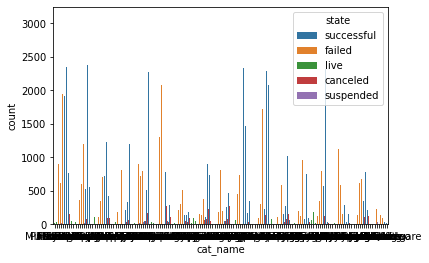

In [19]:
sns.countplot(data=frame_all, x='cat_name', hue='state')

In [ ]:
frame_all

In [ ]:
for i in range(len(frame_all)):
    try:
        frame_all.location.iloc[i].split('"state":"')[1].split('"')[0]
    except:
        print(i)

In [ ]:
frame_all.location.iloc[736] 

In [ ]:
frame_all.category.iloc[100].split('"name":"')[1].split('"')[0]

In [ ]:
frame_all.info()

In [ ]:
frame_all.photo.iloc[100]

In [ ]:
frame_all.creator.iloc[100]